In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from wordcloud import WordCloud
from collections import Counter

In [3]:
df=pd.read_csv("../data/cleaned_reviews_dataset.csv")

In [5]:
for c in df.columns:
    print(f"\"{c}\"",end=", ")

"game_name", "review", "voted_up", "timestamp_created", "author_num_games_owned", "author_num_reviews", "author_playtime_at_review", "author_playtime_last_two_weeks", "author_playtime_forever", 

In [7]:
# we list the columns in our dataset and their data types
df.dtypes

game_name                         object
review                            object
voted_up                            bool
timestamp_created                  int64
author_num_games_owned             int64
author_num_reviews                 int64
author_playtime_at_review          int64
author_playtime_last_two_weeks     int64
author_playtime_forever            int64
dtype: object

### Some summary statistics ->

In [10]:
# we can get summary statistics of all numerical columns
df.describe()

,timestamp_created,author_num_games_owned,author_num_reviews,author_playtime_at_review,author_playtime_last_two_weeks,author_playtime_forever
count,4.292400e+04,42924.000000,42924.000000,4.292400e+04,42924.000000,4.292400e+04
mean,1.715186e+09,69.589460,15.970017,1.115328e+04,433.422724,1.540057e+04
std,4.154933e+07,224.372803,46.055941,4.077951e+04,1084.890568,5.696278e+04
min,1.487494e+09,0.000000,1.000000,4.000000e+00,0.000000,5.000000e+00
25%,1.721491e+09,0.000000,2.000000,6.460000e+02,0.000000,1.031000e+03
50%,1.726010e+09,0.000000,6.000000,2.148500e+03,0.000000,2.995000e+03
75%,1.728177e+09,54.000000,15.000000,6.692500e+03,326.000000,8.014000e+03
max,1.729276e+09,12668.000000,2364.000000,3.145129e+06,20054.000000,3.194464e+06


In [12]:
# we find the mean length of all reviews
(df["review"].apply(len)).mean()

172.69744199049484

In [14]:
# then we can look at the average playtime in hours for all reviews
(df["author_playtime_at_review"]/60).mean()

185.88803466592117

In [16]:
# we look at the median playtime in hours for all reviews
(df["author_playtime_at_review"]/60).median()

35.80833333333334

In [18]:
# we can get the total number of positive and negative reviews in our entire dataset
df["voted_up"].value_counts()

voted_up
True     38625
False     4299
Name: count, dtype: int64

In [20]:
# we can try to analyse if there is any correlation between the playtime and the length of review
df["author_playtime_at_review"].corr(df["review"].apply(len))

-0.011147521877619334

### Data Visualization ->

In [22]:
plt.style.use('dark_background')

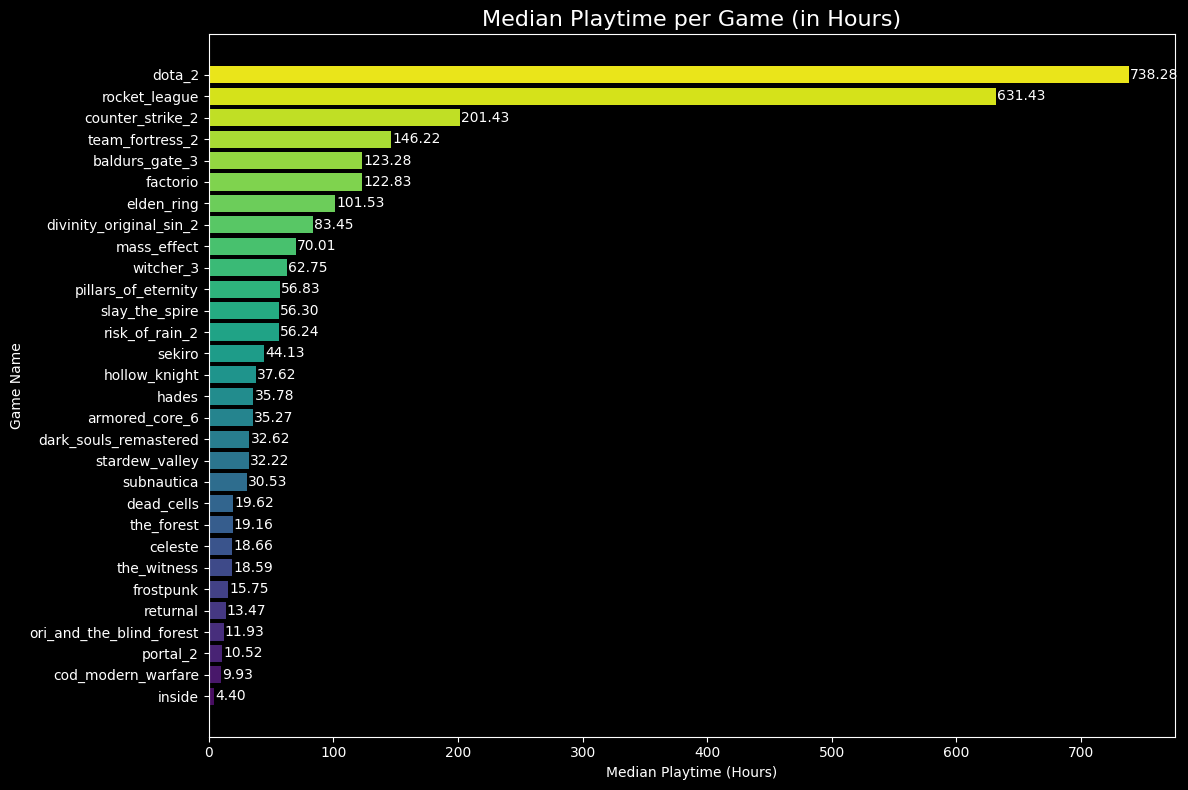

In [26]:
# median playtime for each game 
median_playtime = df.groupby("game_name")["author_playtime_at_review"].median() / 60

median_playtime = median_playtime.sort_values()
colors = sns.color_palette("viridis", len(median_playtime))

plt.figure(figsize=(12, 8))
bars = plt.barh(median_playtime.index, median_playtime.values, color=colors)

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', va='center', fontsize=10)

plt.title("Median Playtime per Game (in Hours)", fontsize=16)
plt.xlabel("Median Playtime (Hours)")
plt.ylabel("Game Name")

plt.tight_layout()

plt.savefig('../graphs/playtime_by_game.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

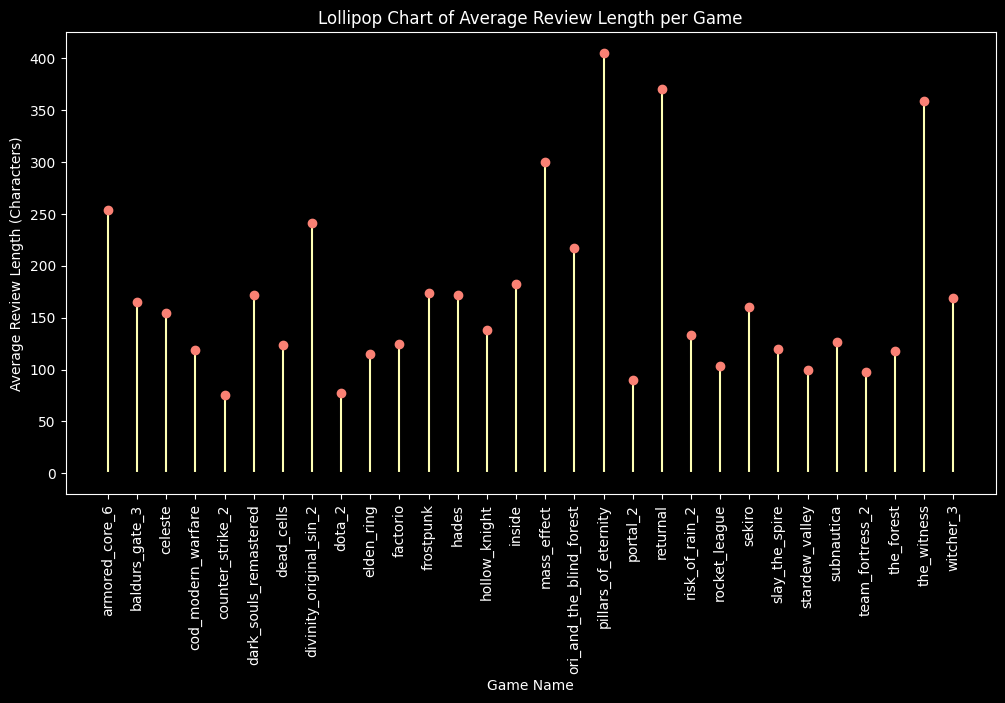

In [32]:
# review length for each game
avg_review_length = df.groupby("game_name")["review"].apply(lambda x: x.str.len().mean())

plt.figure(figsize=(12, 6))
plt.stem(avg_review_length.index, avg_review_length.values, linefmt="C1-", markerfmt="C3o", basefmt="black")
plt.xticks(rotation=90)
plt.title("Lollipop Chart of Average Review Length per Game")
plt.xlabel("Game Name")
plt.ylabel("Average Review Length (Characters)")
plt.savefig('../graphs/review_length_by_game.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

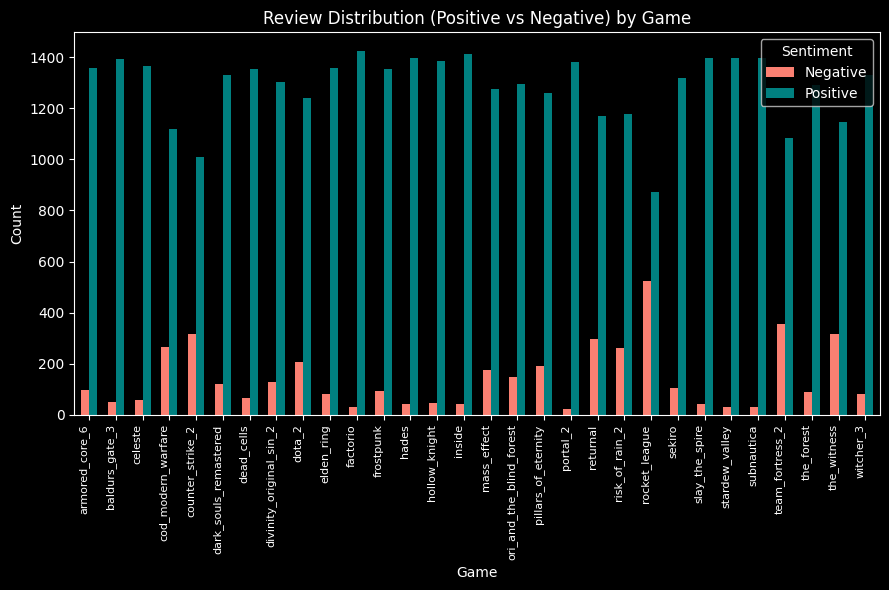

In [34]:
# we look at distribution of positive and negative reviews for each game

sentiment_counts = df.groupby(['game_name', 'voted_up']).size().unstack()

fig, ax = plt.subplots(figsize=(9, 6))

sentiment_counts.plot(kind='bar', ax=ax, width=0.6, color=['salmon', 'teal'])

plt.title('Review Distribution (Positive vs Negative) by Game')
plt.xlabel('Game')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.tight_layout()

plt.savefig('../graphs/review_sentiment_by_game.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

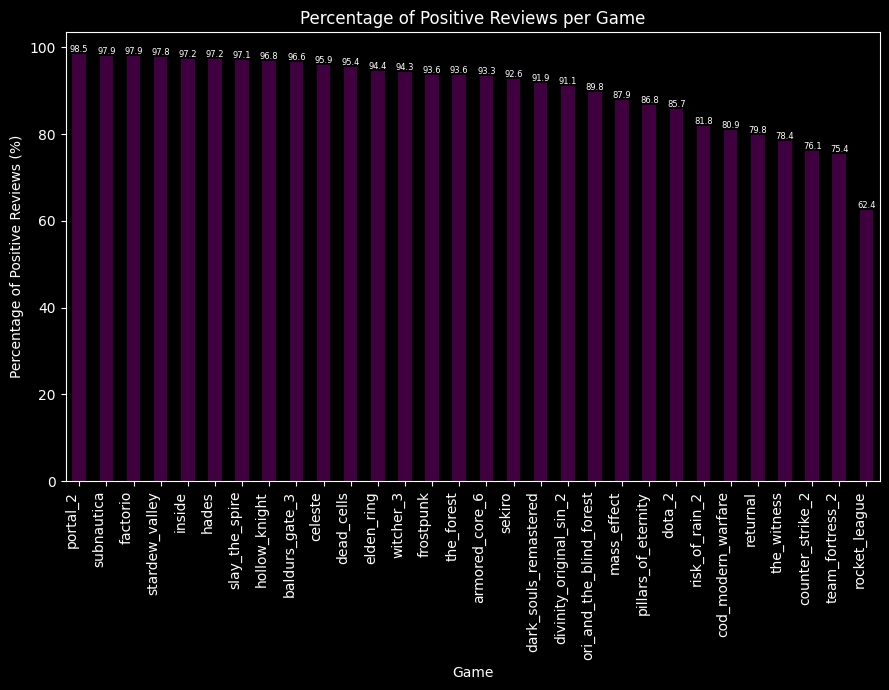

In [36]:
# We then look at percentage of positive reviews for each of our 30 games

sentiment_percent = df.groupby('game_name')['voted_up'].mean() * 100
sentiment_percent = sentiment_percent.sort_values(ascending=False) #we sort them in descending order

fig, ax = plt.subplots(figsize=(9, 7))
bars = sentiment_percent.plot(kind='bar', color='purple', ax=ax, alpha=0.5)


for bar in bars.patches: # we display percentages inside the bars
    ax.annotate(f'{bar.get_height():.1f}',
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at the top center of each bar
                ha='center', va='bottom', fontsize=6)

plt.title('Percentage of Positive Reviews per Game')
plt.xlabel('Game')
plt.ylabel('Percentage of Positive Reviews (%)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.savefig('../graphs/percentage_positive_reviews.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


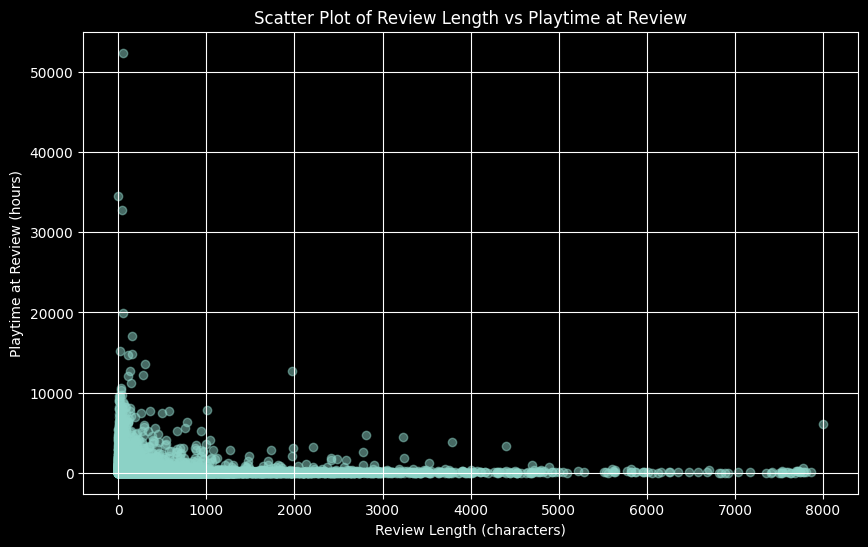

In [38]:
# scatterplot of review length against the playtime
df["review_length"] = df["review"].apply(len)

df["playtime_at_review_hours"] = df["author_playtime_at_review"] / 60 #we get playtime in terms of hours

plt.figure(figsize=(10, 6))
plt.scatter(df["review_length"], df["playtime_at_review_hours"], alpha=0.5)
plt.title("Scatter Plot of Review Length vs Playtime at Review")
plt.xlabel("Review Length (characters)")
plt.ylabel("Playtime at Review (hours)")
# plt.ylim(0,10000)
plt.grid(True)

plt.savefig('../graphs/review_length_vs_playtime.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

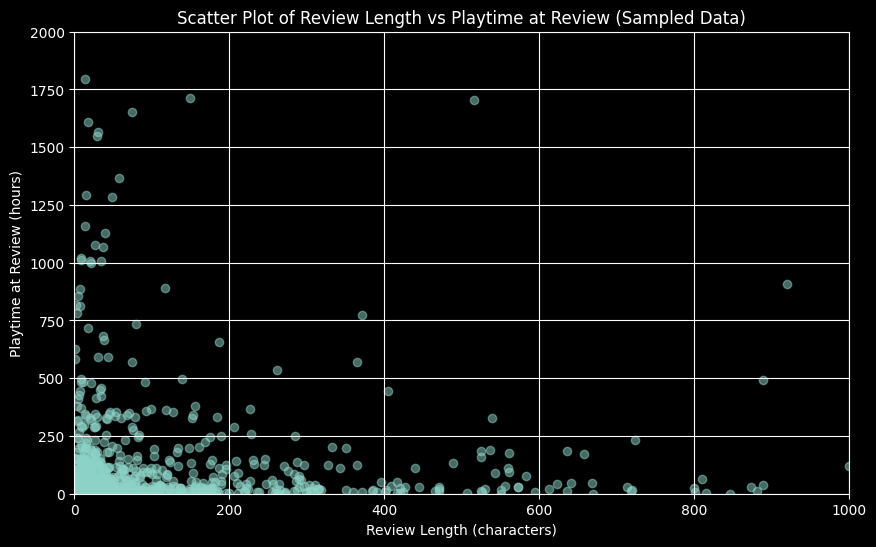

In [39]:
# a sampled version of above plot for better readability
sample_df = df.sample(1000) 

plt.figure(figsize=(10, 6))
plt.scatter(sample_df["review_length"], sample_df["playtime_at_review_hours"], alpha=0.5)
plt.title("Scatter Plot of Review Length vs Playtime at Review (Sampled Data)")
plt.xlabel("Review Length (characters)")
plt.ylabel("Playtime at Review (hours)")

plt.ylim(0,2000) #we limit x and y
plt.xlim(0,1000)

plt.grid(True)
plt.savefig('../graphs/review_length_vs_playtime_sampled_data.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
(df["author_playtime_at_review"]/df["author_playtime_forever"])

0        0.998776
1        0.963788
2        0.711382
3        0.987760
4        1.000000
           ...   
42919    0.015967
42920    0.494370
42921    0.153954
42922    0.584531
42923    0.507713
Length: 42924, dtype: float64

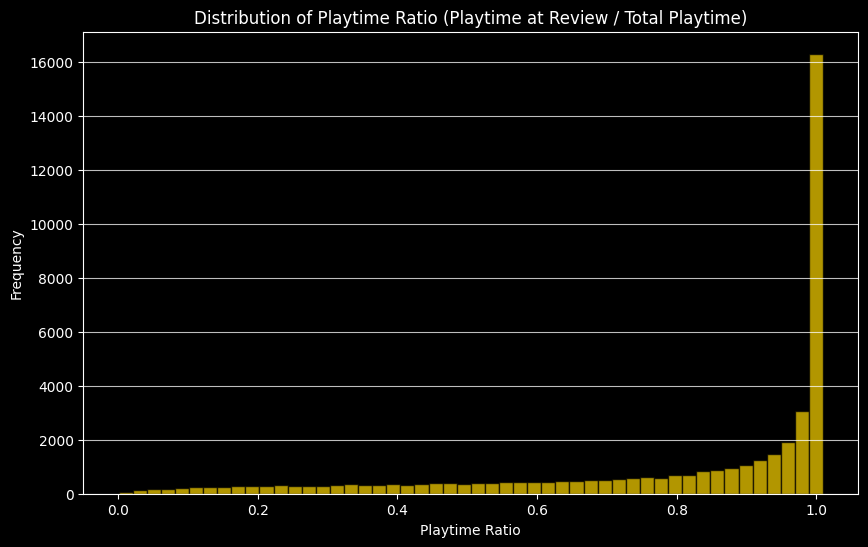

In [52]:
# distribution when people post reviews and how much playtime they actually have
plt.figure(figsize=(10, 6))
plt.hist(df["author_playtime_at_review"]/df["author_playtime_forever"], bins=50, alpha=0.7, edgecolor='black', color="gold")
plt.title("Distribution of Playtime Ratio (Playtime at Review / Total Playtime)")
plt.xlabel("Playtime Ratio")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.savefig('../graphs/distribution_of_playtime_ratio.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

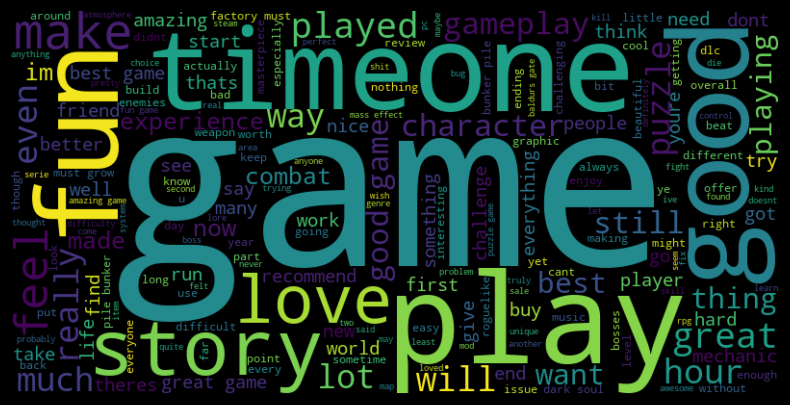

In [70]:
#we generate a word cloud of most frequent words
text = " ".join(review for review in df["review"])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes

plt.savefig('../graphs/word_cloud.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

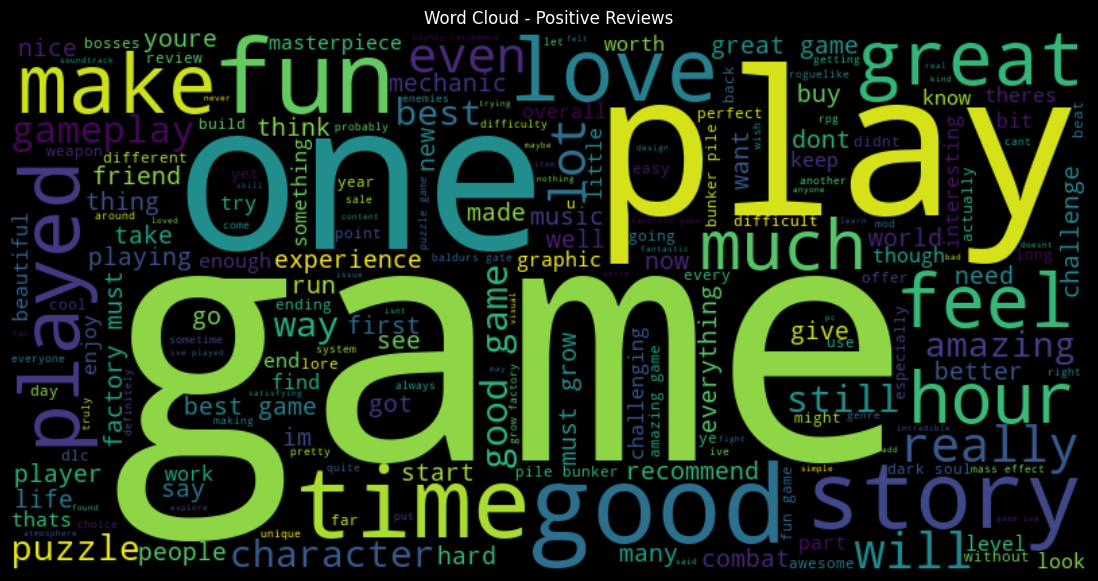

In [68]:
# word cloud for positive reviews
positive_reviews = " ".join(df[df["voted_up"] == True]["review"])
fig, axes = plt.subplots(1, 1, figsize=(15, 7))

wordcloud_pos = WordCloud(width=800, height=400, background_color='black').generate(positive_reviews)
axes.imshow(wordcloud_pos, interpolation='bilinear')
axes.axis('off')
axes.set_title('Word Cloud - Positive Reviews')
plt.savefig('../graphs/wordcloud_positive.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

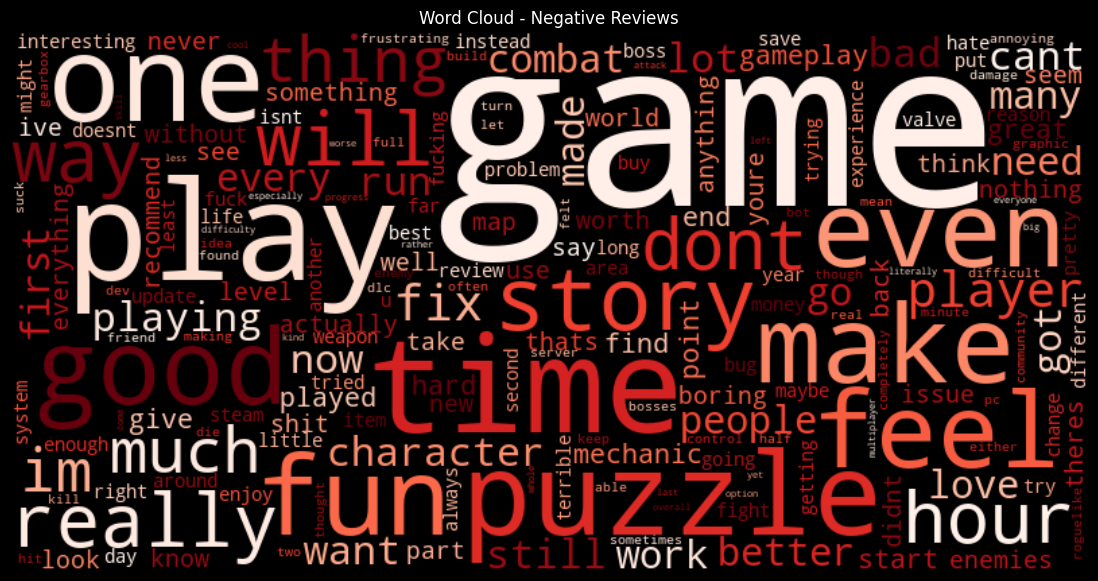

In [66]:
# word cloud for negative reviews
negative_reviews = " ".join(df[df["voted_up"] == False]["review"])

fig, axes = plt.subplots(1, 1, figsize=(15, 7))

wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)
axes.imshow(wordcloud_neg, interpolation='bilinear')
axes.axis('off')
axes.set_title('Word Cloud - Negative Reviews')
plt.savefig('../graphs/wordcloud_negative.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

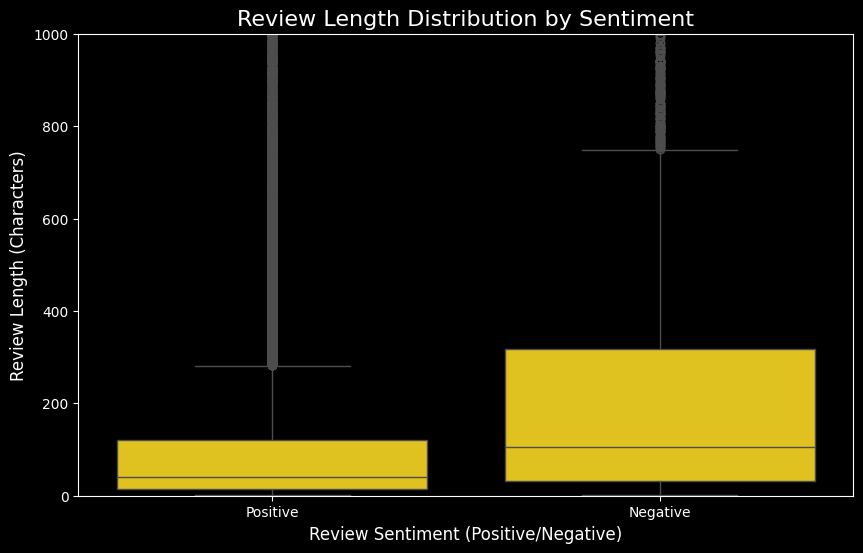

In [58]:
# boxplot of review length for each type of sentiment zoomed in
df["review_length"] = df["review"].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["voted_up"].apply(lambda x: "Positive" if x==True else "Negative"), y="review_length", data=df, color="gold")

plt.title("Review Length Distribution by Sentiment", fontsize=16)
plt.xlabel("Review Sentiment (Positive/Negative)", fontsize=12)
plt.ylabel("Review Length (Characters)", fontsize=12)

plt.ylim(0,1000)

plt.savefig('../graphs/review_length_by_sentiment.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

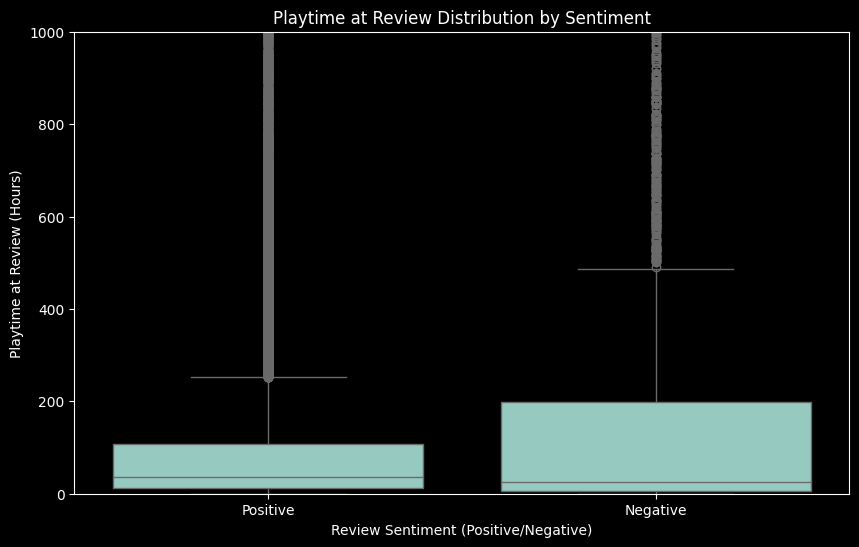

In [59]:
# playtime by sentiment zoomed in
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["voted_up"].apply(lambda x: "Positive" if x==True else "Negative"), y=df["author_playtime_at_review"] / 60, data=df)
plt.title("Playtime at Review Distribution by Sentiment")
plt.xlabel("Review Sentiment (Positive/Negative)")
plt.ylabel("Playtime at Review (Hours)")
plt.ylim(0,1000)
plt.savefig('../graphs/playtime_by_sentiment.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\aniru\AppData\Local\Temp\ipykernel_33856\2386246034.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = df.groupby(['playtime_range', 'voted_up']).size().unstack(fill_value=0)


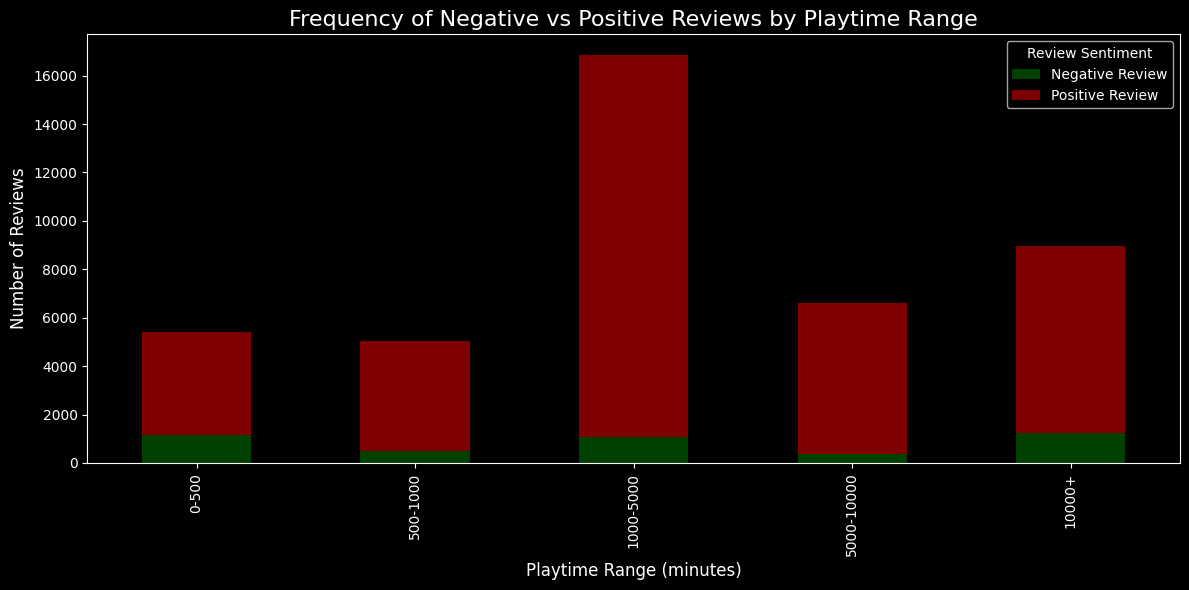

In [61]:
# player sentiment by playtime
bins = [0, 500, 1000, 5000, 10000, float('inf')]
labels = ['0-500', '500-1000', '1000-5000', '5000-10000', '10000+']

df['playtime_range'] = pd.cut(df['author_playtime_forever'], bins=bins, labels=labels, right=False)

sentiment_counts = df.groupby(['playtime_range', 'voted_up']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.5, ax=plt.gca())

plt.title("Frequency of Negative vs Positive Reviews by Playtime Range", fontsize=16)
plt.xlabel("Playtime Range (minutes)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

plt.legend(title="Review Sentiment", labels=["Negative Review", "Positive Review"])

plt.tight_layout()

plt.savefig('../graphs/review_sentiment_by_playtime.png', format='png', dpi=300, bbox_inches='tight')
plt.show()